In [1]:
import os
import sys
from pathlib import Path
path = Path(os.getcwd()).parent
sys.path.append(str(path))

In [2]:
import torch
import torchvision
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from guided_diffusion.unet import create_model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda:0


Image 00458


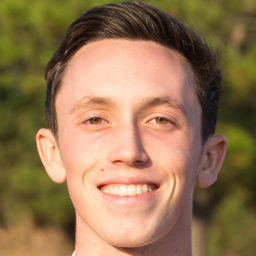

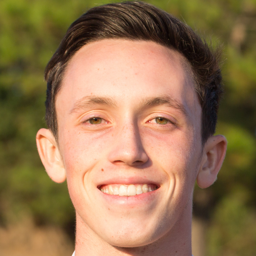

In [3]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t):
  t = 0.5+0.5*t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  display(pil_img)
  return(pil_img)

idx = np.random.randint(1000)
print('Image', str(idx).zfill(5))
img_pil = Image.open(path / Path('ffhq256-1k-validation/'+str(idx).zfill(5)+'.png'))
display(img_pil)
display_as_pilimg(pilimg_to_tensor(img_pil));


In [4]:
pilimg_to_tensor(img_pil).shape

torch.Size([1, 3, 256, 256])

In [5]:
# Load model
model_config = {'image_size': 256,
                'num_channels': 128,
                'num_res_blocks': 1,
                'channel_mult': '',
                'learn_sigma': True,
                'class_cond': False,
                'use_checkpoint': False,
                'attention_resolutions': 16,
                'num_heads': 4,
                'num_head_channels': 64,
                'num_heads_upsample': -1,
                'use_scale_shift_norm': True,
                'dropout': 0.0,
                'resblock_updown': True,
                'use_fp16': False,
                'use_new_attention_order': False,
                'model_path': path / Path('ffhq_10m.pt')}
model = create_model(**model_config)
model = model.to(device)
# use in eval mode:
model.eval();


/raid/home/detectionfeuxdeforet/caillaud_gab/randomd_stuff/guided_diffusion/unet.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load(model_pat

In [6]:
model

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stri

In [7]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

93563910


In [8]:
# Define the model to distill
import torch
import torch.nn as nn
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=64):
        super(UNet, self).__init__()
        
        features = init_features
        self.encoder1 = UNet._block(in_channels + 1, features, name="enc1")  # +1 for t
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")
        
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")
        
        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv(dec1))
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )


cm_model = UNet(in_channels=3, out_channels=3, init_features=64)

In [9]:
sum(p.numel() for p in cm_model.parameters())

31038339

In [10]:
class DDPM:
  def __init__(self, model=model):
    self.num_diffusion_timesteps = 1000
    self.T = self.num_diffusion_timesteps
    self.reversed_time_steps = np.arange(self.num_diffusion_timesteps)[::-1]
    beta_start = 0.0001
    beta_end = 0.02
    self.betas = np.linspace(beta_start, beta_end, self.num_diffusion_timesteps,
                              dtype=np.float64)
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.model = model
    self.imgshape = (1,3,256,256)


  def get_eps_from_model(self, x, t):
    # the model outputs:
    # - an estimation of the noise eps (chanels 0 to 2)
    # - learnt variances for the posterior  (chanels 3 to 5)
    # (see Improved Denoising Diffusion Probabilistic Models
    # by Alex Nichol, Prafulla Dhariwal
    # for the parameterization)
    # We discard the second part of the output for this practice session.
    model.eval()
    with torch.no_grad():
      # model_output = self.model(x, torch.tensor(t, device=device).unsqueeze(0))
      model_output = self.model(x, t.squeeze(1))
      model_output = model_output[:,:3,:,:]
      torch.cuda.empty_cache()
    return(model_output)

  def predict_xstart_from_eps(self, x, eps, t):
    x_start = (
        np.sqrt(1.0 / self.alphas_cumprod[t])* x
        - np.sqrt(1.0 / self.alphas_cumprod[t] - 1) * eps
    )
    x_start = x_start.clamp(-1.,1.)
    return(x_start)

  def sample(self, show_steps=True):
    with torch.no_grad():  # avoid backprop wrt model parameters
      x = torch.randn(self.imgshape,device=device)  # initialize x_t for t=T
      for i, t in enumerate(self.reversed_time_steps):
        if t > 1:
          z = torch.randn_like(x, device=device)
        else:
          z = torch.zeros_like(x, device=device)
        eps = self.get_eps_from_model(x,t)
        # mu = 1 / np.sqrt(self.alphas[t]) * (x - self.betas[t] / np.sqrt(1 - self.alphas_cumprod[t]) * eps)
        mu = self.compute_mu(x, eps, t)
        std = np.sqrt(self.betas[t])
        x = mu + z * std

        if i==0 or t%100==0 or t==0:
          print('Iteration:', i, '; Discrete time:', t)
          if show_steps:
            pilimg = display_as_pilimg(x.cpu())

    return(x)
ddpm  =DDPM()

In [11]:
import torch.nn as nn
class ConsistencyModel(nn.Module):
    def __init__(self, T=120, in_channels=3, out_channels=3, init_features=64):
        super().__init__()
        self.model = UNet(in_channels=in_channels, out_channels=out_channels, init_features=init_features)
        self.T = T
        self.eps = 0.002
        self.in_channels =in_channels
        self.input_dim = 256
        self.out_channels = out_channels
        self.init_features= init_features
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def c_skip(self, t):
        """Skip coefficient ensuring c_skip(eps) = 1."""
        return 1 - ((t - self.eps) / self.T)

    def c_out(self, t):
        """Output coefficient ensuring c_out(eps) = 0."""
        return (t - self.eps) / self.T

    def forward(self, x, t):
        t = t.view(-1, 1, 1,1).expand(-1, 1, 256, 256)  # to use broadcast
        self.model.to("cuda")
        x_t = torch.cat([x, t], dim=1)
        f_theta = self.model(x_t)        
        # Compute skip and output coefficients
        c_skip_t = self.c_skip(t)
        c_out_t = self.c_out(t)

        output = c_skip_t * x + c_out_t * f_theta

        return output

    def one_step_consistency_sampling(self, n_samples, time_steps=None):
        if time_steps is None:
            t_n = 1
        else :
            t_n =  time_steps[-1]
        with torch.no_grad():
            x = torch.randn(n_samples, self.in_channels, self.input_dim, self.input_dim,device=self.device) * t_n
            t_n = torch.full((x.shape[0],),t_n, device=self.device) # sample from last time step
            samples = self.forward(x, t_n)
        return samples.cpu()


def compute_time_steps(N, epsilon=2e-3, T=80, rho=7):
    """
    Compute discretized time steps following Karras et al. (2022).
    """
    return torch.tensor([
        (epsilon**(1/rho) + (i-1)/(N-1) * (T**(1/rho) - epsilon**(1/rho)))**rho
        for i in range(1, N+1)
    ])


def compute_score_function(ddpm, xt, t, n_idx):
    """ Computes the score function s_phi(x_t, t) """
    with torch.no_grad():
        n_idx = n_idx.view(-1, 1)
        eps = ddpm.get_eps_from_model(xt, n_idx) # n_idx/ddpm.T dans 2D distillation

    std = np.sqrt(1 - ddpm.alphas_cumprod[n_idx.cpu().numpy().astype(int)])
    std = torch.tensor(std, device=eps.device).view(-1,1,1,1)
    score = -eps / std
    return score


def compute_x_hat(ddpm, x_tn1, t_n, t_n1, n_idx1):
    """
    Computes the consistency update rule:
    x̂_tn = x_t(n+1) - (t_n - t_n1) * t_n1 * s_phi(x_t(n+1), t_n1)
    """
    # Compute score function s_phi(x_t(n+1), t_n1)
    score_tn1 = compute_score_function(ddpm, x_tn1, t_n1, n_idx1)

    # Compute update step
    x_hat_tn = x_tn1 - (t_n - t_n1).view(-1, 1, 1,1) * t_n1.view(-1, 1, 1,1) * score_tn1

    return x_hat_tn



In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image

class FFHQDataset(Dataset):
    def __init__(self, root_dir=path / Path('ffhq256-1k-validation/')):
        self.root_dir = Path(root_dir)
        self.image_paths = sorted(self.root_dir.glob("*.png"))
        
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        if isinstance(idx, (list, np.ndarray, torch.Tensor)):  # Handle batch access
        
            return torch.stack([self._load_image(self.image_paths[i]) for i in idx], dim=0).squeeze(1)
        return self._load_image(self.image_paths[idx])

    def _load_image(self, img_path):
        img = Image.open(img_path)
        img_tensor = pilimg_to_tensor(img)

        return img_tensor
dataset =FFHQDataset()

In [13]:
import torch.optim as optim
def consistency_distillation(cd_model, ddpm, dataset, epochs=5000, batch_size=128, lr=1e-4, mu=0.99,
                             log_every=500,   lambda_tn = 1):
    """
    Train a consistency model using Consistency Distillation (CD) algorithm.

    Args:
        cd_model: The consistency model to be trained.
        dataset: The training dataset.
        epochs: Number of training iterations.
        batch_size: Number of samples per batch.
        lr: Learning rate for optimization.
        mu: EMA update rate for shadow model.
        N: Number of discrete timesteps.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = optim.Adam(cd_model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # Define distance function d(·,·)

    N = ddpm.T
    # Compute discretized time steps
    time_steps = compute_time_steps(N, T=1).to(device)

    # Shadow model for exponential moving average (EMA)
    cd_model_shadow = ConsistencyModel(T=cd_model.T,in_channels=cd_model.in_channels, out_channels=cd_model.out_channels, init_features=cd_model.init_features)
    cd_model_shadow.load_state_dict(cd_model.state_dict())
    cd_model_shadow.eval()

    cd_model.to("cpu")
    cd_model_shadow.to("cpu")

    for epoch in range(epochs):
        torch.cuda.empty_cache() 
        cd_model.train()
        cd_model_shadow.eval()
        idx = np.random.randint(0, len(dataset), (batch_size,))
        x = dataset[idx].to(device)

        # Sample index from precomputed time steps
        n_idx = torch.randint(0, N - 1, (batch_size,), device=device)
        t_n = time_steps[n_idx]
        n_idx1 = n_idx + 1
        t_n1 = time_steps[n_idx1]  # Ensure t_n1 > t_n

        # Sample x_{t_{n+1}} ~ N(x; t_{n+1}^2 I)
        noise = torch.randn_like(x)
        x_tn1 = x +  t_n1.view(-1, 1, 1, 1) * noise

        # Compute x̂_{t_n} using the update rule
        with torch.no_grad():
            x_hat_tn = compute_x_hat(ddpm, x_tn1, t_n, t_n1, n_idx1).detach()

            cd_model_shadow.to(device)
            # Compute the target f_{\theta^-}(x̂_{t_n}, t_n)
            cm_target = cd_model_shadow(x_hat_tn.float(), t_n.float())
            cd_model_shadow.to("cpu")
        # Model prediction f_θ(x_{t_{n+1}}, t_{n+1})
        cd_model.to(device)
        cm_pred = cd_model(x_tn1, t_n1)
     
        # print(f"{cm_pred.device=}", f"{cm_target.device=}")
        loss =lambda_tn * criterion(cm_pred, cm_target).mean()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
           
        cd_model.to("cpu")
        del cm_target, cm_pred  # Release memory used by these tensors
        torch.cuda.empty_cache() 
        x.to("cpu")
        # EMA update for shadow model
        with torch.no_grad():
            for param, shadow_param in zip(cd_model.parameters(), cd_model_shadow.parameters()):
                shadow_param.data = mu * shadow_param.data + (1 - mu) * param.data.detach()
  
        print(f"Epoch {str(epoch).rjust(5)}, Loss: {loss.item():.6f}")
        if epoch % log_every == 0 or epoch==epochs-1:
            print(f"Epoch {str(epoch).rjust(5)}, Loss: {loss.item():.6f}")
            # samples = multistep_consistency_sampling(cd_model, N, n_samples=1000, device=device).numpy()
            samples = cd_model.one_step_consistency_sampling(n_samples=4, time_steps=time_steps)
            pilimg = display_as_pilimg(samples[0])

In [14]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


Epoch     0, Loss: 22.042036
Epoch     0, Loss: 22.042036


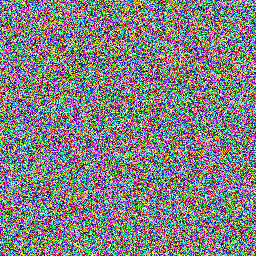

Epoch     1, Loss: 97.828949
Epoch     2, Loss: 281.837280
Epoch     3, Loss: 396.408173
Epoch     4, Loss: 238.694870
Epoch     5, Loss: 453.950104
Epoch     6, Loss: 124.851700
Epoch     7, Loss: 22.552849
Epoch     8, Loss: 537.939514
Epoch     9, Loss: 204.652756
Epoch    10, Loss: 441.252563
Epoch    11, Loss: 123.586494
Epoch    12, Loss: 327.976044
Epoch    13, Loss: 283.060577
Epoch    14, Loss: 296.665619
Epoch    15, Loss: 106.358543
Epoch    16, Loss: 213.974869
Epoch    17, Loss: 49.257927
Epoch    18, Loss: 153.107727
Epoch    19, Loss: 211.269379
Epoch    20, Loss: 544.606445
Epoch    20, Loss: 544.606445


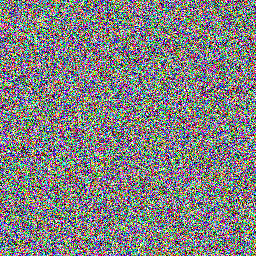

Epoch    21, Loss: 247.203918
Epoch    22, Loss: 762.428711
Epoch    23, Loss: 346.267639
Epoch    24, Loss: 347.686951
Epoch    25, Loss: 17.780310
Epoch    26, Loss: 381.586487
Epoch    27, Loss: 476.717285
Epoch    28, Loss: 317.227509
Epoch    29, Loss: 221.799973
Epoch    30, Loss: 56.368599
Epoch    31, Loss: 298.108826
Epoch    32, Loss: 219.248856
Epoch    33, Loss: 378.480408
Epoch    34, Loss: 234.663544
Epoch    35, Loss: 217.541260
Epoch    36, Loss: 304.474213
Epoch    37, Loss: 520.390686
Epoch    38, Loss: 199.679977
Epoch    39, Loss: 350.415222
Epoch    40, Loss: 357.437378
Epoch    40, Loss: 357.437378


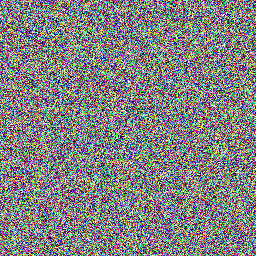

Epoch    41, Loss: 385.558075
Epoch    42, Loss: 219.378647
Epoch    43, Loss: 17.655943
Epoch    44, Loss: 56.851795
Epoch    45, Loss: 104.410789
Epoch    46, Loss: 233.243149
Epoch    47, Loss: 262.859283
Epoch    48, Loss: 502.032990
Epoch    49, Loss: 108.298355
Epoch    50, Loss: 52.203594
Epoch    51, Loss: 351.940796
Epoch    52, Loss: 271.444305
Epoch    53, Loss: 162.264252
Epoch    54, Loss: 367.395569
Epoch    55, Loss: 126.538780
Epoch    56, Loss: 181.954376
Epoch    57, Loss: 325.580200
Epoch    58, Loss: 158.655380
Epoch    59, Loss: 59.386314
Epoch    60, Loss: 278.293243
Epoch    60, Loss: 278.293243


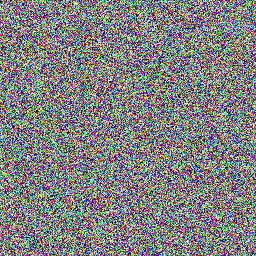

Epoch    61, Loss: 28.074800
Epoch    62, Loss: 254.352600
Epoch    63, Loss: 418.890594
Epoch    64, Loss: 184.673187
Epoch    65, Loss: 27.975039
Epoch    66, Loss: 311.207214
Epoch    67, Loss: 396.564209
Epoch    68, Loss: 29.879419
Epoch    69, Loss: 84.334061
Epoch    70, Loss: 189.131470
Epoch    71, Loss: 476.902924
Epoch    72, Loss: 352.641541
Epoch    73, Loss: 199.790085
Epoch    74, Loss: 209.338821
Epoch    75, Loss: 406.722260
Epoch    76, Loss: 548.842773
Epoch    77, Loss: 225.032486
Epoch    78, Loss: 6.410231
Epoch    79, Loss: 75.703590
Epoch    80, Loss: 234.842117
Epoch    80, Loss: 234.842117


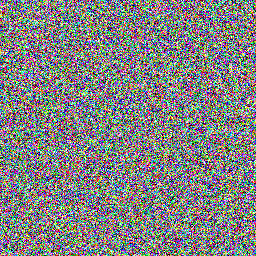

Epoch    81, Loss: 321.466949
Epoch    82, Loss: 389.197540
Epoch    83, Loss: 480.694489
Epoch    84, Loss: 123.876747
Epoch    85, Loss: 112.878639
Epoch    86, Loss: 584.020752
Epoch    87, Loss: 393.419586
Epoch    88, Loss: 356.872437
Epoch    89, Loss: 346.146820
Epoch    90, Loss: 247.215866
Epoch    91, Loss: 43.689667
Epoch    92, Loss: 268.293549
Epoch    93, Loss: 60.780643
Epoch    94, Loss: 299.738861
Epoch    95, Loss: 85.150322
Epoch    96, Loss: 139.592041
Epoch    97, Loss: 41.774555
Epoch    98, Loss: 304.650543
Epoch    99, Loss: 23.446589
Epoch   100, Loss: 198.699005
Epoch   100, Loss: 198.699005


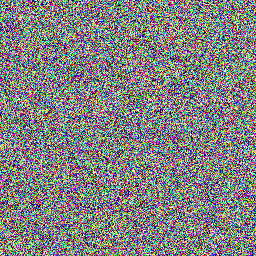

Epoch   101, Loss: 295.435883
Epoch   102, Loss: 378.913330
Epoch   103, Loss: 134.809341
Epoch   104, Loss: 842.754822
Epoch   105, Loss: 186.500992
Epoch   106, Loss: 296.951263
Epoch   107, Loss: 157.802002
Epoch   108, Loss: 182.087936
Epoch   109, Loss: 316.694611
Epoch   110, Loss: 200.284714
Epoch   111, Loss: 114.758812
Epoch   112, Loss: 118.148102
Epoch   113, Loss: 247.923737
Epoch   114, Loss: 433.602570
Epoch   115, Loss: 353.178925
Epoch   116, Loss: 179.608978
Epoch   117, Loss: 143.066681
Epoch   118, Loss: 101.786400
Epoch   119, Loss: 454.759369
Epoch   120, Loss: 109.938187
Epoch   120, Loss: 109.938187


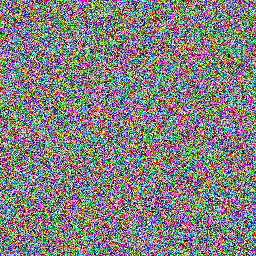

Epoch   121, Loss: 259.085297
Epoch   122, Loss: 315.221619
Epoch   123, Loss: 6.692711
Epoch   124, Loss: 240.823669
Epoch   125, Loss: 293.233673
Epoch   126, Loss: 130.438232
Epoch   127, Loss: 196.445786
Epoch   128, Loss: 118.796432
Epoch   129, Loss: 628.321228
Epoch   130, Loss: 81.821701
Epoch   131, Loss: 727.112000
Epoch   132, Loss: 571.681458
Epoch   133, Loss: 161.621155
Epoch   134, Loss: 381.655060
Epoch   135, Loss: 198.014069
Epoch   136, Loss: 237.804993
Epoch   137, Loss: 437.606415
Epoch   138, Loss: 154.840149
Epoch   139, Loss: 132.145386
Epoch   140, Loss: 2.691545
Epoch   140, Loss: 2.691545


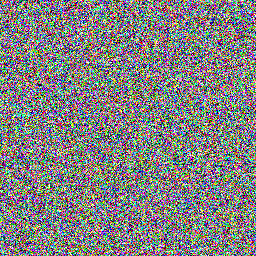

Epoch   141, Loss: 104.952904
Epoch   142, Loss: 250.598663
Epoch   143, Loss: 30.690855


In [ ]:
ddpm.T = 25
cd_model = ConsistencyModel(T=25,in_channels=3, out_channels=3, init_features=4)
consistency_distillation(cd_model, ddpm, dataset, epochs=1000, batch_size=16, lr=1e-4, mu=0.25,
                             log_every=20,   lambda_tn = 1000)